In [ ]:
# Python PEP 8 styling guide recommends using lower case with underscores as opposed to camel case

In [ ]:
# Exploratory Data Analysis (EBA)
# Why:
# Understand the shape of the data
# Learn which features might be useful
# Inform the cleaning that will come next
# How:
# Get counts and distributions of all variables, determine each features data type and correlations
# and deal with missing data and duplications

# Data Cleaning
# Why:
# Shape data in a fashion a model can best pick up on any availble signals
# Remove irrelevant data
# Adjust features to be acceptable to the model
# How:
# Ananonymize and fill in any missing data if necessary, encode categorical variables and prune or scale
# the data to account for skewed data and or outliers

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

# Sklearn will send a warning when it's methods will change in future updates, 
# this is simply hidding those messages
warnings.filterwarnings('ignore', category = FutureWarning)

In [52]:
# Reading in the data
titanic_df = pd.read_csv('../../Data/TitanicTrainingData.csv')

In [21]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Dropping all categorical features
# Mainly for ease of data exploration at the moment, some of these features are potentially useful
categorical_features = ['PassengerId', 'Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']
titanic_df.drop(categorical_features, axis = 1, inplace = True)

In [6]:
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [7]:
# Exploring continous features
# Age has missing data values base on the available count
# Survived is a binary feature whose mean can be used to determine the percentage of surviving passengers, ~38%
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Looking for which features may be significant in terms of determining a passenger's survival
# Fare and passenger class appear at first glance to be possible leads
titanic_df.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887
1,1.950292,28.343690,0.473684,0.464912,48.395408


In [9]:
# Determining whether or not the missing age values are random or in a systematic way
# For example, the ages of those in first class might not have been asked their ages
# This determines how the missing data should be handled
# Those whose ages weren't recorded seemed to have paid lower fares, being in lower classes, as well as having
# traveled with fewer people on average, which means those in the bowels of the ship might have avoided records
# Otherwise, nothing in particular stands out signifying the missing data has to be treated in a specific manner
titanic_df.groupby(titanic_df['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


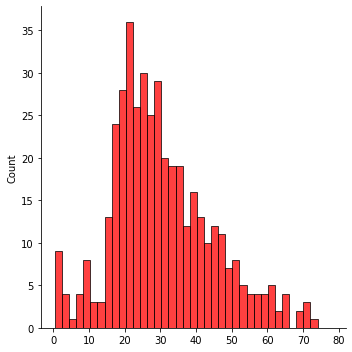

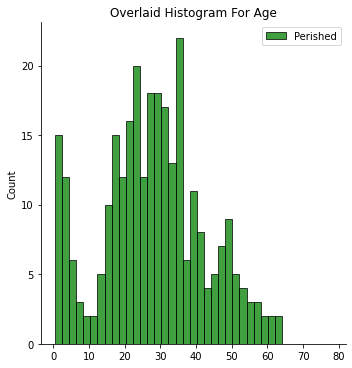

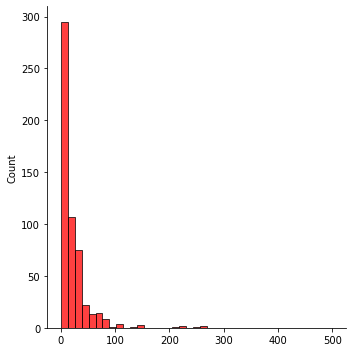

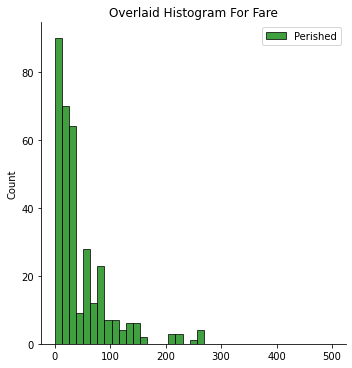

In [14]:
# Plotting continous features
# Desire to understand the shape of the features and how they relate to the target variable
# Overlaid histograms between survivors and those who perished is one way to accomplish this
# Utilizing the continous variables of 'Age' and 'Fare'
for i in ['Age', 'Fare']:
    # Grabbing non missing values into 2 lists of the dead and survivors
    died = list(titanic_df[titanic_df['Survived'] == 0][i].dropna())
    survived = list(titanic_df[titanic_df['Survived'] == 1][i].dropna())
    
    x_min = min(min(died), min(survived))
    x_max = max(max(died), max(survived))
    width = (x_max - x_min) / 40
    
    # Plotting the 2 lists of grabbed values onto an overlaid histogram
    sns.displot(died, color = 'r', kde = False, bins = np.arange(x_min, x_max, width))
    sns.displot(survived, color = 'g', kde = False, bins = np.arange(x_min, x_max, width))
    
    plt.legend(['Perished', 'Survived'])
    plt.title('Overlaid Histogram For {}'.format(i))
    plt.show()

<Figure size 432x288 with 0 Axes>

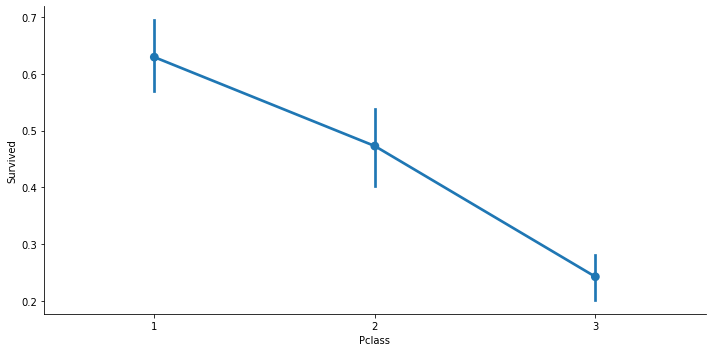

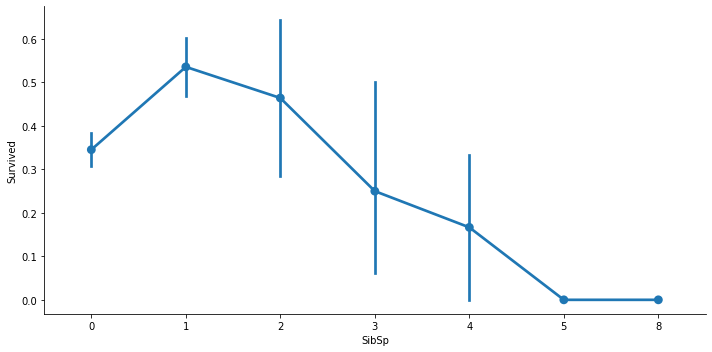

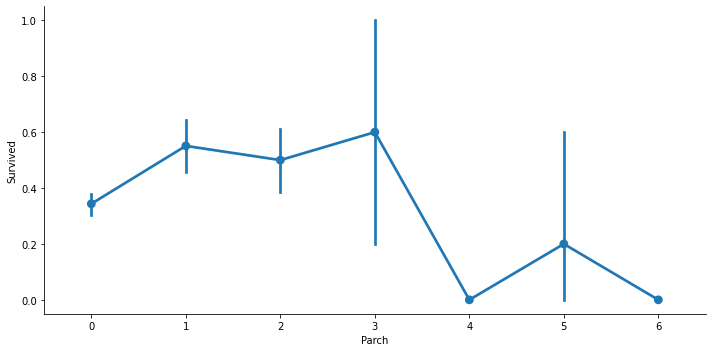

In [15]:
# Categorical plot to determine survival rate based upon the categorical features various levels
# Telling seaborn to create a new plot for every iteration through the loop
# Presents the percent of people whom survived based on the categorical variables values, along with error bars
# The larger the ammount of data, the smaller the error bar and the greater confidence
# Passenger class appears to have an obvious impact on survival, as well as those with many familly members
for index, column in enumerate(['Pclass', 'SibSp', 'Parch']):
    plt.figure(index)
    sns.catplot(x = column, y = 'Survived', data = titanic_df, kind = 'point', aspect = 2)

In [16]:
# Combining the parents and siblinbs columns into a single value column
titanic_df['FamilyCount'] = titanic_df['SibSp'] + titanic_df['Parch']

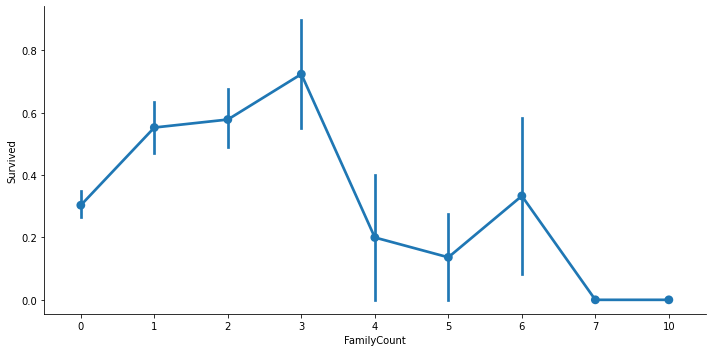

In [19]:
# The combined columns' patterns generally persist, whith those with many familly members being more likely
# to perish in the sinking
# If you can combine columns whilst maintaining the same general pattern or trend it is a good idea to do so
# It cleans up the data by given the model fewer things to look at
sns.catplot(x = 'FamilyCount', y = 'Survived', data = titanic_df, kind = 'point', aspect = 2)

In [22]:
# Continous data cleaning
# Dropping irrelevant continous variables
# 'inplace': Whether to create a new standalone dataframe or alter the current dataframe
titanic_df.drop('PassengerId', axis = 1, inplace = True)

In [23]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
# Filling in the missing age variable values
# Using the most naive method to do this by filling in the missing values with the average age,
# avoiding biasing the model towards one direction or another
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)

In [26]:
# Checking that there are no longer any missing values within the dataframe's columns
titanic_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [27]:
titanic_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C


In [28]:
# Dropping individual columns used to create the combined column to avoid multicollinearity issues because
# they are highly correlated and will otherwise confuse the model
titanic_df['FamilyCount'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)

In [30]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilyCount
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [32]:
# Exploring categorical features
# Often done seperately due to the different methods in exploring continous and categorical features
continous_features = ['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Fare']
titanic_df.drop(continous_features, axis = 1, inplace = True)

In [33]:
titanic_df.head()

,Survived,Sex,Ticket,Cabin,Embarked
0,0,male,A/5 21171,NaN,S
1,1,female,PC 17599,C85,C
2,1,female,STON/O2. 3101282,NaN,S
3,1,female,113803,C123,S
4,0,male,373450,NaN,S


In [34]:
# Getting a general overhead view
# Quite a few missing values for the 'Cabin' feature
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.9+ KB


In [35]:
# Dramatic split between those whose cabin numbers were recorded and not missing (False) and those's who were 
# (True) in terms of their average chances of survival
# The missing value must mean something as so should be handled in a specific fashion
titanic_df.groupby(titanic_df['Cabin'].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


In [45]:
# If the passenger had a cabin, then 1, if not then 0
# Encoded as indicator variable since the cabin feature means something
titanic_df['CabinIndicator'] = np.where(titanic_df['Cabin'].isnull(), 0, 1)

In [38]:
titanic_df.head()

,Survived,Sex,Ticket,Cabin,Embarked,CabinIndicator
0,0,male,A/5 21171,NaN,S,0
1,1,female,PC 17599,C85,C,1
2,1,female,STON/O2. 3101282,NaN,S,0
3,1,female,113803,C123,S,1
4,0,male,373450,NaN,S,0


<Figure size 432x288 with 0 Axes>

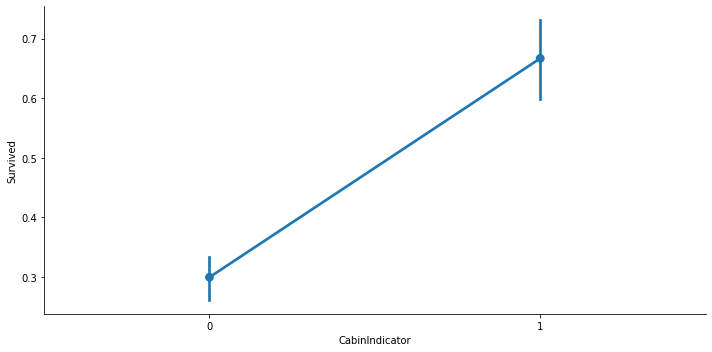

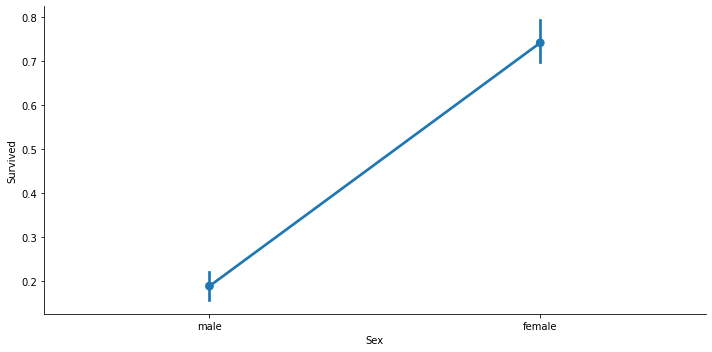

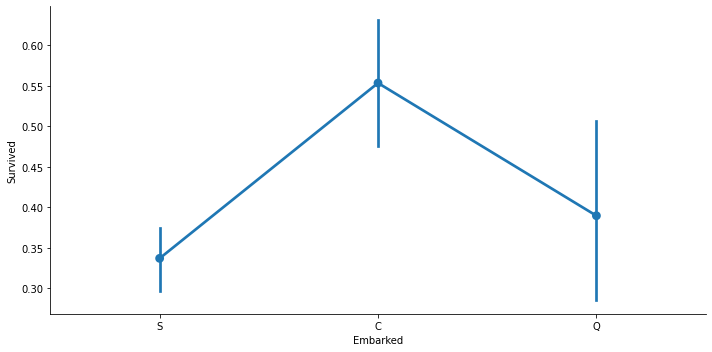

In [39]:
# Plotting categorical variables
for index, column in enumerate(['CabinIndicator', 'Sex', 'Embarked']):
    plt.figure(index)
    sns.catplot(x = column, y = 'Survived', data = titanic_df, kind = 'point', aspect = 2)

In [40]:
# Understand the survival rating based on port of embarkation by comparing to 'Sex'
# Fewer people survived from Southhampton because they were mostly men
titanic_df.pivot_table('Survived', index = 'Sex', columns = 'Embarked', aggfunc = 'count')

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


In [41]:
# Understand the survival rating based on port of embarkation by comparing to whether or not the had a cabin
# More people from Cherbourg survived as they had cabins
# Overall embarked is repetetive in an indirect fashion by showing the very strong features of sex and cabin
# ownership and is in it of itself not that useful to the model, and so should be done away with
titanic_df.pivot_table('Survived', index = 'CabinIndicator', columns = 'Embarked', aggfunc = 'count')

Embarked,C,Q,S
CabinIndicator,,,
0,99,73,515
1,69,4,129


In [43]:
# Cleaning the categorical data
titanic_df.drop(['Name', 'Ticket'], axis = 1, inplace = True)

In [46]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,CabinIndicator
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,0
1,2,1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,1
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,0


In [47]:
# Converting 'Sex' variable feature to numeric
# Dictionary to handle the gender to numeric mapping which will then be 
# applied to the Titanic dataframe's 'Sex' column
gender_number = {'male': 0, 'female': 1}

titanic_df['Sex'] = titanic_df['Sex'].map(gender_number)

In [48]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,CabinIndicator
0,1,0,3,0,22.0,1,0,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,71.2833,C85,C,1
2,3,1,3,1,26.0,0,0,7.9250,NaN,S,0
3,4,1,1,1,35.0,1,0,53.1000,C123,S,1
4,5,0,3,0,35.0,0,0,8.0500,NaN,S,0


In [49]:
# Dropping 'Cabin' and 'Embarked' feature columns
titanic_df.drop(['Cabin', 'Embarked'], axis = 1, inplace = True)

In [50]:
titanic_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,CabinIndicator
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,1
4,5,0,3,0,35.0,0,0,8.0500,0


In [56]:
# Splitting the dataset
# Training: Used to train the model and where the algorithm is allowed to learn from
# Validation: Used to select the best model for the most optimal algorithm and hyperparameter tuning
# Testing: Used to provide and unbiased evaluation of what the model will look like in a real environment

features = titanic_df.drop('Survived', axis = 1)
labels = titanic_df['Survived']

# Initializion seed in order to reproduce the same output when the code is run
# The 'train_test_split' cannot split a dataset into 3 groups, so to obtain a validation dataset a 2 step
# process has to be carried out
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [57]:
print(len(labels), len(y_train), len(y_validation), len(y_test))

891 534 179 178


In [58]:
# Holdout Test Set: Essentially the validation and testing datasets
# Sample of data not used in fitting a model, used to evaluate the model's ability to generalize to unseen data

# K-Fold Cross Validation
# Data is divided into k subsets and the holdout method is repeated k-times. Each time one of the the k-subsets
# is used as the test set and the other k-1 subsets are combined to be used to train the model

# Evaluation Framework
# Metrics: How is the model's accuracy gauged
# Process: How to split the data, how is the full dataset leveraged to mitigate the 
# likelyhood of overfitting & underfitting
# 1. Run 5 fold cross validation on the training dataset and select the best models
# 2. Re-fit the models on a full training dataset, evaluate those models on 
# the validation dataset and pick the best on
# 3. Evaluate the best model on the test dataset to gauge its ability to generalize to unseen data

# Titanic passenger survival is a classification problem
# Accuracy = # predicted correctly / total # of examples
# Precision = # predicted as surviving that actually survived / total # predicted to survive
# Recall = # predicted as surviving that actually survived / total # that actually survived

In [59]:
# Bias: Algorithm's tendency to consistently learn the wrong thing by not taking into account all of the 
# the information in the data

# High Bias: Result of the algorithm missing the relevant relations between features and target outputs

# Variance: An algorithm's sensitivity to small fluctuations in the training set
# High Variance: Result of the algorithm fitting to random noise in the training data

# Bias Variance Tradeoff: Using dart board analogy
# Low Bias + Low Variance: All darts in the bullsey
# Low Biad + High Variance: Darts spread out around the bullsey
# High Bias + Low Variance: All darts condensed somewhere other than the bullsey
# High Bias + High Variance: Darts spread out around a point other than the bullsey

# Total Error = (Bias + Variance) + Irreducible Noise

# Models:
# Simple: Underfitting, low complexity and variance, high bias, training and testing error
# Good: Medium complexity, low bias, variance, training and testing error
# Complex: Overfitting, high complexity, variance and testing error, low bias and training error

# Hyperparameter Tuning: Choosing a set of optimal hypeparameters for fitting an algorithm
# Parameter: Configuration variable that is internal to the model and whose value can be estimated from the data
# Hyperparamter: Configuration that is external to the model, whose value cannot be estimated from the data
# and whose value guides how the algorithm learns parameter values from the data (Example: Decision Tree Depth)

# Regularization: Technique used to avoid overfitting by discouraging overly complex models in some way
# Goal is to allow enough flexibity for the algorithm to learn the underlying patterns in the data but provide
# guardrails so it doesn't overfit

# Ridge & Lasso Regressiob: Adding a penalty to the loss function to constrain coefficients, 
# the model has to greatly increase in accuracy before it is allowed to become more complex

# Dropout: Some nodes are ignored during training which forces the other nodes to take on more or less 
# responsibility for the input / output, more for deep leaning and neural networks

# Occams' Razor: Whenever possible, choose the simplest answer to a problem
# Choose the most simple model possible that will provide accurate predictions

In [61]:
# Full Process
# Loading in the original Titanic dataset
titanic_df = pd.read_csv('../../Data/TitanicTrainingData.csv')

# Cleaning the continous features
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
titanic_df['FamilyCount'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df.drop(['PassengerId', 'SibSp', 'Parch'], axis = 1, inplace = True)

# Cleaning the categorical features
titanic_df['CabinIndicator'] = np.where(titanic_df['Cabin'].isnull(), 0, 1)
gender_number = {'male': 0, 'female': 1}
titanic_df['Sex'] = titanic_df['Sex'].map(gender_number)
titanic_df.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis = 1, inplace = True)

# Splitting the dataset
features = titanic_df.drop('Survived', axis = 1)
labels = titanic_df['Survived']
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

for dataset in [y_train, y_validation, y_test]:
    print(round(len(dataset) / len(labels), 2))

# Write out to cleaned data
# Do not save the index as if the file is read in at a later time by Pandas, it will see the index as a 
# feature and cout it as a new column
titanic_df.to_csv('../../Data/CleanedTitanicData.csv', index = False)

0.6
0.2
0.2


In [65]:
# Fitting a basic model using 5 fold cross-validation
rf = RandomForestClassifier()

# A warning may appear indicating that sklearn prefers column labels as an array rather than a pandas column vector
scores = cross_val_score(rf, features, labels.values.ravel(), cv = 5)

In [66]:
scores

array([0.79329609, 0.79213483, 0.85955056, 0.78651685, 0.86516854])

In [68]:
# For easier to understand results
def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [69]:
# Tuning hyperparameters
parameters = {
    'n_estimators': [5, 50 , 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv = 5)
cv.fit(features, labels.values.ravel())

print_results(cv)

Best Parameters: {'max_depth': 10, 'n_estimators': 50}

0.796 (+/-0.048) for {'max_depth': 2, 'n_estimators': 5}
0.794 (+/-0.064) for {'max_depth': 2, 'n_estimators': 50}
0.781 (+/-0.061) for {'max_depth': 2, 'n_estimators': 100}
0.816 (+/-0.063) for {'max_depth': 10, 'n_estimators': 5}
0.831 (+/-0.043) for {'max_depth': 10, 'n_estimators': 50}
0.828 (+/-0.045) for {'max_depth': 10, 'n_estimators': 100}
0.795 (+/-0.068) for {'max_depth': 20, 'n_estimators': 5}
0.824 (+/-0.068) for {'max_depth': 20, 'n_estimators': 50}
0.825 (+/-0.076) for {'max_depth': 20, 'n_estimators': 100}
0.806 (+/-0.096) for {'max_depth': None, 'n_estimators': 5}
0.827 (+/-0.062) for {'max_depth': None, 'n_estimators': 50}
0.818 (+/-0.075) for {'max_depth': None, 'n_estimators': 100}


In [71]:
# Evaluating results on validation set

# Refiting the best 3 cross validation models on the remaining validation dataset, 
# as so far only 80% of the training data has benn used

rf1 = RandomForestClassifier(n_estimators = 50, max_depth = 10)
rf1.fit(features, labels.values.ravel())

rf2 = RandomForestClassifier(n_estimators = 50, max_depth = 100)
rf2.fit(features, labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators = 50, max_depth = None)
rf3.fit(features, labels.values.ravel())

RandomForestClassifier(n_estimators=50)

In [74]:
for md1 in [rf1, rf2, rf3]:
    y_pred = md1.predict(x_validation)
    accuracy = round(accuracy_score(y_validation, y_pred), 3)
    precision = round(precision_score(y_validation, y_pred), 3)
    recall = round(recall_score(y_validation, y_pred), 3)
    print('Max Depth: {} / # Of Est: {} -- A: {} / P: {} / R: {}'.format(md1.max_depth, 
                                                                         md1.n_estimators, 
                                                                         accuracy, 
                                                                         precision,
                                                                         recall))

Max Depth: 10 / # Of Est: 50 -- A: 0.939 / P: 0.945 / R: 0.908
Max Depth: 100 / # Of Est: 50 -- A: 1.0 / P: 1.0 / R: 1.0
Max Depth: None / # Of Est: 50 -- A: 1.0 / P: 1.0 / R: 1.0


In [75]:
y_pred = rf2.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
print('Max Depth: {} / # Of Est: {} -- A: {} / P: {} / R: {}'.format(md1.max_depth,
                                                                     md1.n_estimators, 
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

Max Depth: None / # Of Est: 50 -- A: 0.989 / P: 0.985 / R: 0.985
